A hydrostatic, inviscid, adiabatic, and dry system in isentropic coordinates
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import tasmania as taz

# For interactive plotting
from IPython import display
%matplotlib nbagg

Load the computational grid and the initial state
--

In [2]:
grid, states = taz.load_netcdf_dataset('../tests/baseline_datasets/isentropic_dry.nc')
state = states[0]

Instantiate the dynamical core
--

In [3]:
# Adopt the flux form of the three-stage Runge-Kutta time integration method,
# coupled with a fifth-order upwind advection scheme
dycore = taz.IsentropicDynamicalCore(
    grid, moist_on=False, time_integration_scheme='rk3cosmo',
    horizontal_flux_scheme='fifth_order_upwind', horizontal_boundary_type='relaxed',
    damp_on=True, damp_type='rayleigh', damp_depth=15, damp_max=0.0002, damp_at_every_stage=False,
    smooth_on=True, smooth_type='third_order', smooth_coeff=0.24, smooth_at_every_stage=False,
    backend=gt.mode.NUMPY, dtype=np.float32
)

Create a monitor for interactive visualization
--

In [4]:
# The drawers and the artist generating the left subplot
drawer1_properties = {
    'fontsize': 16, 'cmap_name': 'BuRd', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 2, 
    'cbar_center': 15, 'cbar_half_width': 8.5,
    'cbar_orientation': 'horizontal',
    'cbar_x_label': 'Horizontal velocity [m s$^{-1}$]',
    'draw_vertical_levels': False,
}
drawer1 = taz.Contourf(
    grid, 'horizontal_velocity', 'm s^-1', z=-1,  
    xaxis_units='km', yaxis_units='km', properties=drawer1_properties,
)
drawer2_properties = {
    'fontsize': 16, 'x_step': 2, 'y_step': 2, 'colors': 'black',
    'draw_vertical_levels': False, 'alpha': 0.5,
}
drawer2 = taz.Quiver(
    grid, z=-1, xaxis_units='km', yaxis_units='km',
    xcomp_name='x_velocity', xcomp_units='m s^-1',
    ycomp_name='y_velocity', ycomp_units='m s^-1',
    properties=drawer2_properties
)
topo_drawer = taz.Contour(
    grid, 'topography', 'km', z=-1, xaxis_units='km', yaxis_units='km',
    properties={'colors': 'darkgray'}
)
axes1_properties = {
    'fontsize': 16, 'title_left': '$\\theta = 300$ K',
    'x_label': '$x$ [km]', 'x_lim': [0, 500],
    'y_label': '$y$ [km]', 'y_lim': [-250, 250],
}
plot1 = taz.Plot((drawer1, drawer2, topo_drawer), axes_properties=axes1_properties)

# The drawer and the artist generating the right subplot
drawer3_properties = {
    'fontsize': 16, 'cmap_name': 'BuRd', 'cbar_on': True, 
    'cbar_levels': 18, 'cbar_ticks_step': 2, 
    'cbar_center': 15, 'cbar_half_width': 8.5,
    'cbar_orientation': 'horizontal',
    'cbar_x_label': '$x$-velocity [m s$^{-1}$]',
    'draw_vertical_levels': True,
}
drawer3 = taz.Contourf(
    grid, 'x_velocity_at_u_locations', 'm s^-1', y=25,  
    xaxis_units='km', zaxis_name='height', zaxis_units='km',
    properties=drawer3_properties,
)
topo_drawer = taz.LineProfile(
    grid, 'topography', 'km', y=25, z=-1, axis_units='km',
    properties={'linecolor': 'black', 'linewidth': 1.3}
)
axes3_properties = {
    'fontsize': 16, 'title_left': '$y = 0$ km',
    'x_label': '$x$ [km]', 'x_lim': [0, 500],
    'y_label': '$z$ [km]', 'y_lim': [0, 14],
}
plot2 = taz.Plot((topo_drawer, drawer3), axes_properties=axes3_properties)

# The monitor encompassing and coordinating the two artists
figure_properties = {'fontsize': 16, 'figsize': (12, 7), 'tight_layout': True}
monitor = taz.PlotComposite(
    nrows=1, ncols=2, artists=(plot1, plot2), interactive=False, figure_properties=figure_properties
)

Run the simulation
--

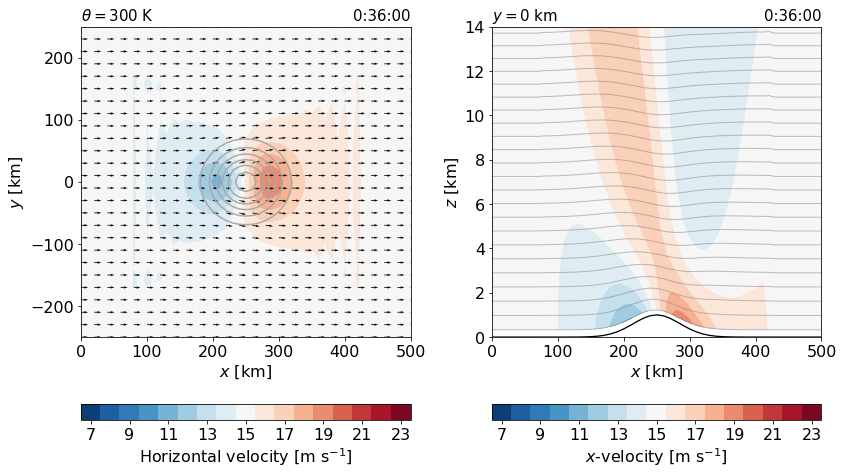

KeyboardInterrupt: 

In [5]:
# Simulation settings
timestep = timedelta(seconds=24)
niter    = 1800

for i in range(niter):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1)*timestep)
    
    # Step the solution
    state_new = dycore(state, {}, timestep)
    state.update(state_new)

    if (i+1) % 30 == 0:
        # Plot the solution
        plot1.axes_properties['title_right'] = str((i+1)*timestep)
        plot2.axes_properties['title_right'] = str((i+1)*timestep)
        fig = monitor.store(((state, state, state), (state, state)), show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')